In [1]:
import numpy as np
import pandas as pd
# from seaborn import despine
import matplotlib.pyplot as plt
plt.rc("axes.spines", top=False, right=False)

from analysis_functions import compute_gaze_influence, q1, q3, iqr, std, se, make_sure_path_exists

/Users/felixmolter/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
make_sure_path_exists('results/descriptives')
make_sure_path_exists('results/figures')

In [3]:
np.random.seed(16) # from random.org

# Load data (full data set)

In [4]:
# load data
data = pd.read_csv('data/krajbich_2011_pnas/data_pnas2011_preprocessed.csv')
data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,item_value_2,gaze_0,gaze_1,gaze_2,fixation_count,ndt,best_chosen,longest_chosen,value_left_minus_mean_others
0,0,0,1,1782,1,7,3,0.096864,0.791638,0.111498,4,347.0,True,True,-4.0
1,0,1,1,1063,7,3,2,0.177738,0.500898,0.321364,4,506.0,False,True,4.5
2,0,2,2,1171,3,1,2,0.534224,0.000000,0.465776,3,572.0,False,False,1.5
3,0,3,0,1368,3,1,2,0.626604,0.000000,0.373396,4,511.0,True,True,1.5
4,0,4,0,1476,6,1,3,0.340448,0.488794,0.170758,4,539.0,True,False,4.0


# Load functions

In [5]:
def aggregate_subject_level(data):
    """
    """
    # Summarize variables
    subject_summary = data.groupby('subject').agg({'rt': ['mean', std, 'min', 'max', se, q1, q3, iqr],
                                                   'best_chosen': 'mean'})
    # Influence of gaze on P(choose left)
    subject_summary['gaze_influence'] = compute_gaze_influence(data)
    
    return subject_summary

In [6]:
def aggregate_group_level(subject_summary):
   
    group_summary = subject_summary.agg({('rt', 'mean'): ['mean', std, 'min', 'max', se, iqr],
                                         ('best_chosen', 'mean'): ['mean', std, 'min', 'max', se, iqr],
                                         'gaze_influence': ['mean', std, 'min', 'max', se, iqr]})
    group_summary = group_summary[[('rt', 'mean'), ('best_chosen', 'mean'), ('gaze_influence')]].copy()
    group_summary.columns = ['Mean RT', 'P(choose best)', 'Gaze Influence']
    return group_summary.T

In [7]:
def plot_individual_differences(values, errorbars=None,
                                reference=None,
                                xlabel='Subject', ylabel='',
                                xlim=None, ylim=None,
                                yticks=None,
                                yticklabels=None,
                                fontsize_axeslabel=15,
                                fontsize_ticklabels=12,
                                sort=True,
                                ax=None):
    """
    values: 1D array
    errorbars: 2D array (n x 2) with lower and upper limits for errorbars
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    if sort:
        sort_idx = np.argsort(values)[::-1]
        values = values[sort_idx]
        if errorbars is not None:
            errorbars = errorbars[sort_idx, :]

    x = np.arange(len(values))
    ax.scatter(x, values, facecolor='white', edgecolor='k',
               s=16,
               linewidth=1,
               zorder=2)
    
    if errorbars is not None:
        ax.vlines(x, errorbars[:, 0], errorbars[:, 1],
                  linewidth=1,
                  zorder=1)
    
    if reference is not None:
        ax.axhline(reference,
                   linewidth=1,
                   linestyle='--',
                   color='k')
    
    ax.set_xticks([])
    if yticks is not None:
        ax.set_yticks(yticks)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels, fontsize=fontsize_ticklabels)
    ax.set_xlabel(xlabel, fontsize=fontsize_axeslabel)
    ax.set_ylabel(ylabel, fontsize=fontsize_axeslabel)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    return ax

In [8]:
def figure_2(subject_summary, figsize=(10, 3)):
    fig, axs = plt.subplots(1, 3, figsize=figsize)
    
    plot_individual_differences(subject_summary['rt']['mean'],
                            subject_summary['rt'][['q1', 'q3']].values,
                            ylabel='Mean RT (ms)',
                            ylim=(0, 8500),
                            yticks=np.arange(0, 9000, 1000),
                            yticklabels=['0', '', '2000', '', '4000', '', '6000', '', '8000'],
                            ax=axs[0])
    
    plot_individual_differences(subject_summary['best_chosen']['mean'],
                            reference=1/3,
                            ylabel='P(choose best)',
                            ylim=(0.25, 1.05),
                            yticks=np.arange(0.3, 1.1, 0.1),
                            yticklabels=['', '0.4', '', '0.6', '', '0.8', '', '1.0'],
                            ax=axs[1])
    
    plot_individual_differences(subject_summary['gaze_influence'],
                            reference=0,
                            ylabel='Gaze influence\non P(choose left)',
                            ylim=(-0.25, 0.65),
                            yticks=np.arange(-0.2, 0.7, 0.1),
                            yticklabels=['-0.2', '', '0', '', '0.2', '', '0.4', '', '0.6'],
                            ax=axs[2])
    
    # Labels
    for label, ax in zip(list('ABC'), axs.ravel()):
        ax.text(-0.15, 1.15, label, transform=ax.transAxes,
                fontsize=20, fontweight='bold', va='top')
    
    fig.tight_layout()
    return fig, axs

# Summarise data to subject level

In [9]:
subject_summary = aggregate_subject_level(data)
subject_summary.to_csv('results/descriptives/subject_summary.csv')
subject_summary

rt                                                          \
                mean          std   min    max          se       q1       q3   
subject                                                                        
0        1235.850000   301.092224   706   2107   30.260907   992.00  1437.25   
1        2190.090000  1146.533149   822   7260  115.230917  1465.50  2663.75   
2        1848.837838   753.718637   838   4506   88.216094  1345.75  2083.00   
3        1540.840000   803.404465   629   5797   80.745187  1007.75  1793.50   
4        2210.560000   762.973791   874   4403   76.681751  1664.50  2586.00   
5        2803.180000  1207.948752  1100   8489  121.403417  2127.25  3336.75   
6        5873.720000  2809.849676  1438  16545  282.400518  3708.25  7222.00   
7        2402.090000  1249.476403   887   6819  125.577103  1383.25  2984.75   
8        1006.340000   202.620888   625   1546   20.364165   840.75  1157.00   
9        2296.100000  1723.221492   811  12400  173.190276  1455.75  2590.75   
10       1707.610000   637.154532   674   3970   64.036440  1260.00  2089.25   
11       1263.020000   305.295299   756   2220   30.683332  1039.75  1433.75   
12       2055.030000   784.440686   787   4608   78.839255  1455.75  2542.75   
13       2199.490000   949.915286  1057   5825   95.470078  1587.25  2501.50   
14       1449.280000   337.503543   894   2586   33.920382  1253.25  1604.25   
15       6216.650000  3706.876940  1886  20585  372.555150  3568.75  7691.25   
16       2447.390000  2217.500462   644  14168  222.867182  1384.25  2667.00   
17       2755.230000   971.001863  1361   6834   97.589359  2128.00  3265.00   
18       1197.290000   413.608639   583   2952   41.569232   930.75  1391.25   
19       1946.695652   879.727091   768   5210   92.220457  1266.50  2345.25   
20       3825.400000  2730.517332  1133  13545  274.427317  1857.00  4649.00   
21       1866.290000   681.803260   767   3862   68.523806  1397.25  2196.00   
22       2703.150000  1069.964545  1000   6605  107.535483  1912.00  3091.25   
23       3024.200000  1670.932015   850  12473  167.934986  1810.25  3635.50   
24       5591.020000  2764.389227  1640  14955  277.831571  3636.75  7010.75   
25       2083.620000  1040.401863   711   5637  104.564321  1288.25  2697.00   
26       1442.210000   470.801705   733   3044   47.317352  1044.00  1792.75   
27       2077.250000  1088.766884   839   6250  109.425189  1359.00  2365.25   
28       2910.820000  1288.982416   983   6664  129.547607  1938.75  3574.75   
29       1703.740000   530.553082   975   3548   53.322591  1352.75  1877.75   

                 best_chosen gaze_influence  
             iqr        mean                 
subject                                      
0         445.25    0.730000       0.223491  
1        1198.25    0.750000       0.251092  
2         737.25    0.783784       0.113825  
3         785.75    0.760000       0.195993  
4         921.50    0.790000       0.137450  
5        1209.50    0.650000       0.475324  
6        3513.75    0.660000       0.185659  
7        1601.50    0.500000       0.583617  
8         316.25    0.730000       0.282559  
9        1135.00    0.590000       0.456388  
10        829.25    0.840000       0.170207  
11        394.00    0.700000       0.289265  
12       1087.00    0.800000       0.140457  
13        914.25    0.800000       0.134559  
14        351.00    0.830000       0.084429  
15       4122.50    0.720000       0.127391  
16       1282.75    0.740000       0.198378  
17       1137.00    0.950000       0.046600  
18        460.50    0.740000       0.219206  
19       1078.75    0.608696       0.239750  
20       2792.00    0.820000       0.100913  
21        798.75    0.640000       0.480938  
22       1179.25    0.590000       0.236608  
23       1825.25    0.730000       0.184508  
24       3374.00    0.530000       0.414231  
25       1408.75    0.630000       0.333007  
26        748.75    0.650000       0.501803

# Summarise data to group level

In [10]:
group_summary = aggregate_group_level(subject_summary)
group_summary.to_csv('results/descriptives/group_summary.csv')
group_summary

,mean,std,min,max,se,iqr
Mean RT,2462.433116,1298.372118,1006.3400,6216.650000,241.101650,1037.502500
P(choose best),0.719416,0.100058,0.5000,0.950000,0.018580,0.138446
Gaze Influence,0.249118,0.137048,0.0466,0.583617,0.025449,0.177672


# Make Figure 2

Close Figure to continue...


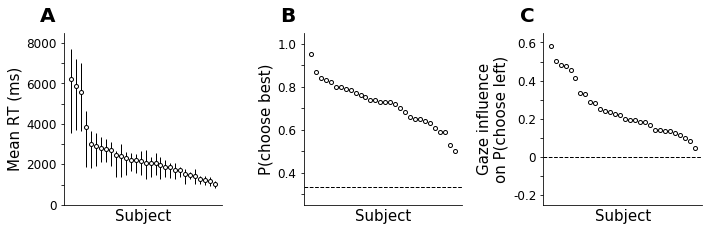

In [11]:
print('Close Figure to continue...')
figure_2(subject_summary)
plt.savefig('results/figures/figure_2_individual_differences.png', dpi=330, bbox_inches='tight')
plt.show()